In [1]:
import numpy as np
import pdb
from env.ofdm_env import ISAC_BS
from copy import deepcopy

In [2]:
env = ISAC_BS(N=8,N_c=8,N_r=8)
# Power Configurations
env.P_r = np.diag(np.ones(env.N))*1.0 # Power of Sensing
env.P_c = np.diag(np.ones(env.N))*0.5 # Power of Communication
rewards = []
SUM_R_P_s=[]
SUM_C_P_s=[]
SUM_R_c_s=[]
SUM_MI_r_s=[]
EE_C_s=[]
EE_R_s=[]
#
record_U = []
record_D = []

# 

In [4]:
controller_dict = ["ranUranD","revUranD","indexUranD"]
# controller = "revUranD"
controller = "ranUranD"
for i in range(40000):
    Hc_max_id = np.argmax(env.H_c,axis=0)
    Hc_max_sort_id = np.argsort(-env.H_c,axis=0)[:,0]
    Hr_max_id = np.argmax(env.H_r,axis=0)
    Hcr_min_id = np.argmin(env.H_cr,axis=0)
    sc = np.eye(env.N,dtype=np.int64)[Hc_max_id]
    sr = np.eye(env.N,dtype=np.int64)[Hr_max_id]
    sc_rev = np.eye(env.N,dtype=np.int64)[:,Hc_max_sort_id]
    # "revUranD"
    if controller == "revUranD":
        env.U = sc_rev
        action_d = np.random.randint(env.N_r,size=env.N)
        D_SET = np.eye(env.N_r)
        env.D = D_SET[:,action_d]
        SUM_R_P,SUM_C_P,SUM_R_c,SUM_MI_r,EE_C,EE_R = env.get_performance()
        next_state,reward,done=env.step(action=None,freeze=True)
        reward_revU_ranD.append(reward)
        
        if reward > 1.0:
            record_U.append(env.U)
            record_D.append(env.D)
        rewards.append(reward)
        SUM_R_P_s.append(SUM_R_P)
        SUM_C_P_s.append(SUM_C_P)
        SUM_R_c_s.append(SUM_R_c)
        SUM_MI_r_s.append(SUM_MI_r)
        EE_C_s.append(EE_C)
        EE_R_s.append(EE_R)
        
    # "ranUranD"
    if controller == "ranUranD":
        # env.D = np.random.binomial(1,0.5,(env.N_r,env.N))
        # env.U = np.random.binomial(1,0.5,(env.N_c,env.N))
        # env.U = np.eye(env.N_c,env.N)
        action_u = np.random.randint(env.N_c,size=env.N)
        action_d = np.random.randint(env.N_r,size=env.N)
        U_SET = np.eye(env.N_c)
        D_SET = np.eye(env.N_r)
        env.U = U_SET[:,action_u]
        env.D = D_SET[:,action_d]
        SUM_R_P,SUM_C_P,SUM_R_c,SUM_MI_r,EE_C,EE_R = env.get_performance()
        next_state,reward,done=env.step(action=None,freeze=True)
        reward_ranU_ranD.append(reward)
        # reward_indexU_ranD.append(reward)
        
        if reward > 1.0:
            record_U.append(env.U)
            record_D.append(env.D)
        rewards.append(reward)
        SUM_R_P_s.append(SUM_R_P)
        SUM_C_P_s.append(SUM_C_P)
        SUM_R_c_s.append(SUM_R_c)
        SUM_MI_r_s.append(SUM_MI_r)
        EE_C_s.append(EE_C)
        EE_R_s.append(EE_R)
   

In [5]:
reward_naive = []
reward_rand = []
for i in range(40000):
    env._naive_allocation()
    SUM_R_P,SUM_C_P,SUM_R_c,SUM_MI_r,EE_C,EE_R = env.get_performance()
    reward = env.reward_to_go(EE_C,EE_R)
    reward_naive.append(reward)
    env._random_allocation()
    SUM_R_P,SUM_C_P,SUM_R_c,SUM_MI_r,EE_C,EE_R = env.get_performance()
    reward = env.reward_to_go(EE_C,EE_R)
    reward_rand.append(reward)
    env.step(freeze=False)
print(max(reward_naive))
print(max(reward_rand))

1.0784151089225023
3.2114638268188056


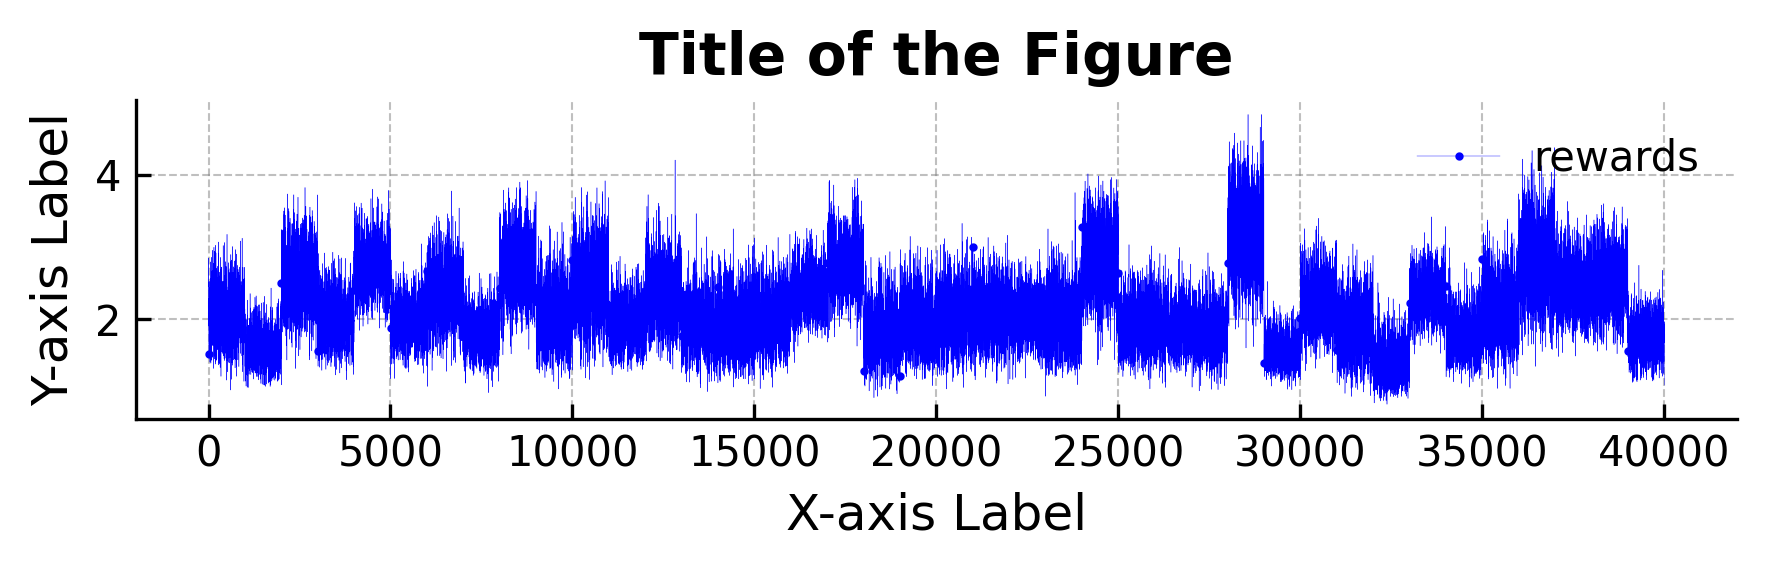

In [116]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
x = np.linspace(0, 40000, 40000)
# y1 = np.array(rewards) 
y1 = np.array(SUM_R_c_s)/np.array(SUM_C_P_s)/(5*1e4) + np.array(SUM_MI_r_s)/np.array(SUM_R_P_s)/10.0
y2 = np.array(SUM_R_P_s)
y3 = np.array(SUM_C_P_s)
y4 = np.array(SUM_R_c_s)/np.array(SUM_C_P_s)/(5*1e4)
y5 = np.array(SUM_MI_r_s)/np.array(SUM_R_P_s)/10.0
# y4 = np.array(EE_C_s)
# y5 = np.array(EE_R_s)
y6 = np.array(SUM_R_c_s)
y7 = np.array(SUM_MI_r_s)

# Create figure
fig, ax = plt.subplots(figsize=(6, 2), dpi=300)

# Set plot style with line and markers
ax.plot(x, y1, label='rewards', color='b', linewidth=0.1, marker='o', markersize=1, linestyle='-', markevery=1000)
# ax.plot(x, y2, label='SUM_R_P_s', color='r', linewidth=0.1, marker='<', markersize=1, linestyle='-', markevery=1000)
# ax.plot(x, y3, label='SUM_C_P_s', color='g', linewidth=0.1, marker='>', markersize=1, linestyle='-', markevery=1000)
# ax.plot(x, y4, label='EE_C_s', color='c', linewidth=0.1, marker='.', markersize=1, linestyle='-', markevery=1000)
# ax.plot(x, y5, label='EE_R_s', color='m', linewidth=0.1, marker='*', markersize=1, linestyle='-', markevery=1000)
# ax.plot(x, y6, label='SUM_R_c_s', color='g', linewidth=0.1, marker='*', markersize=1, linestyle='-', markevery=1000)
# ax.plot(x, y7, label='SUM_MI_r_s', color='m', linewidth=0.1, marker='*', markersize=1, linestyle='-', markevery=1000)

# Set axis labels
ax.set_xlabel('X-axis Label', fontsize=12)
ax.set_ylabel('Y-axis Label', fontsize=12)

# Set title
ax.set_title('Title of the Figure', fontsize=14, fontweight='bold')

# Set legend
ax.legend(loc='upper right', fontsize=10, frameon=False)

# Set tick parameters
ax.tick_params(axis='both', which='both', direction='in', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set grid
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# Set figure layout
fig.tight_layout()


# Show figure
plt.show()


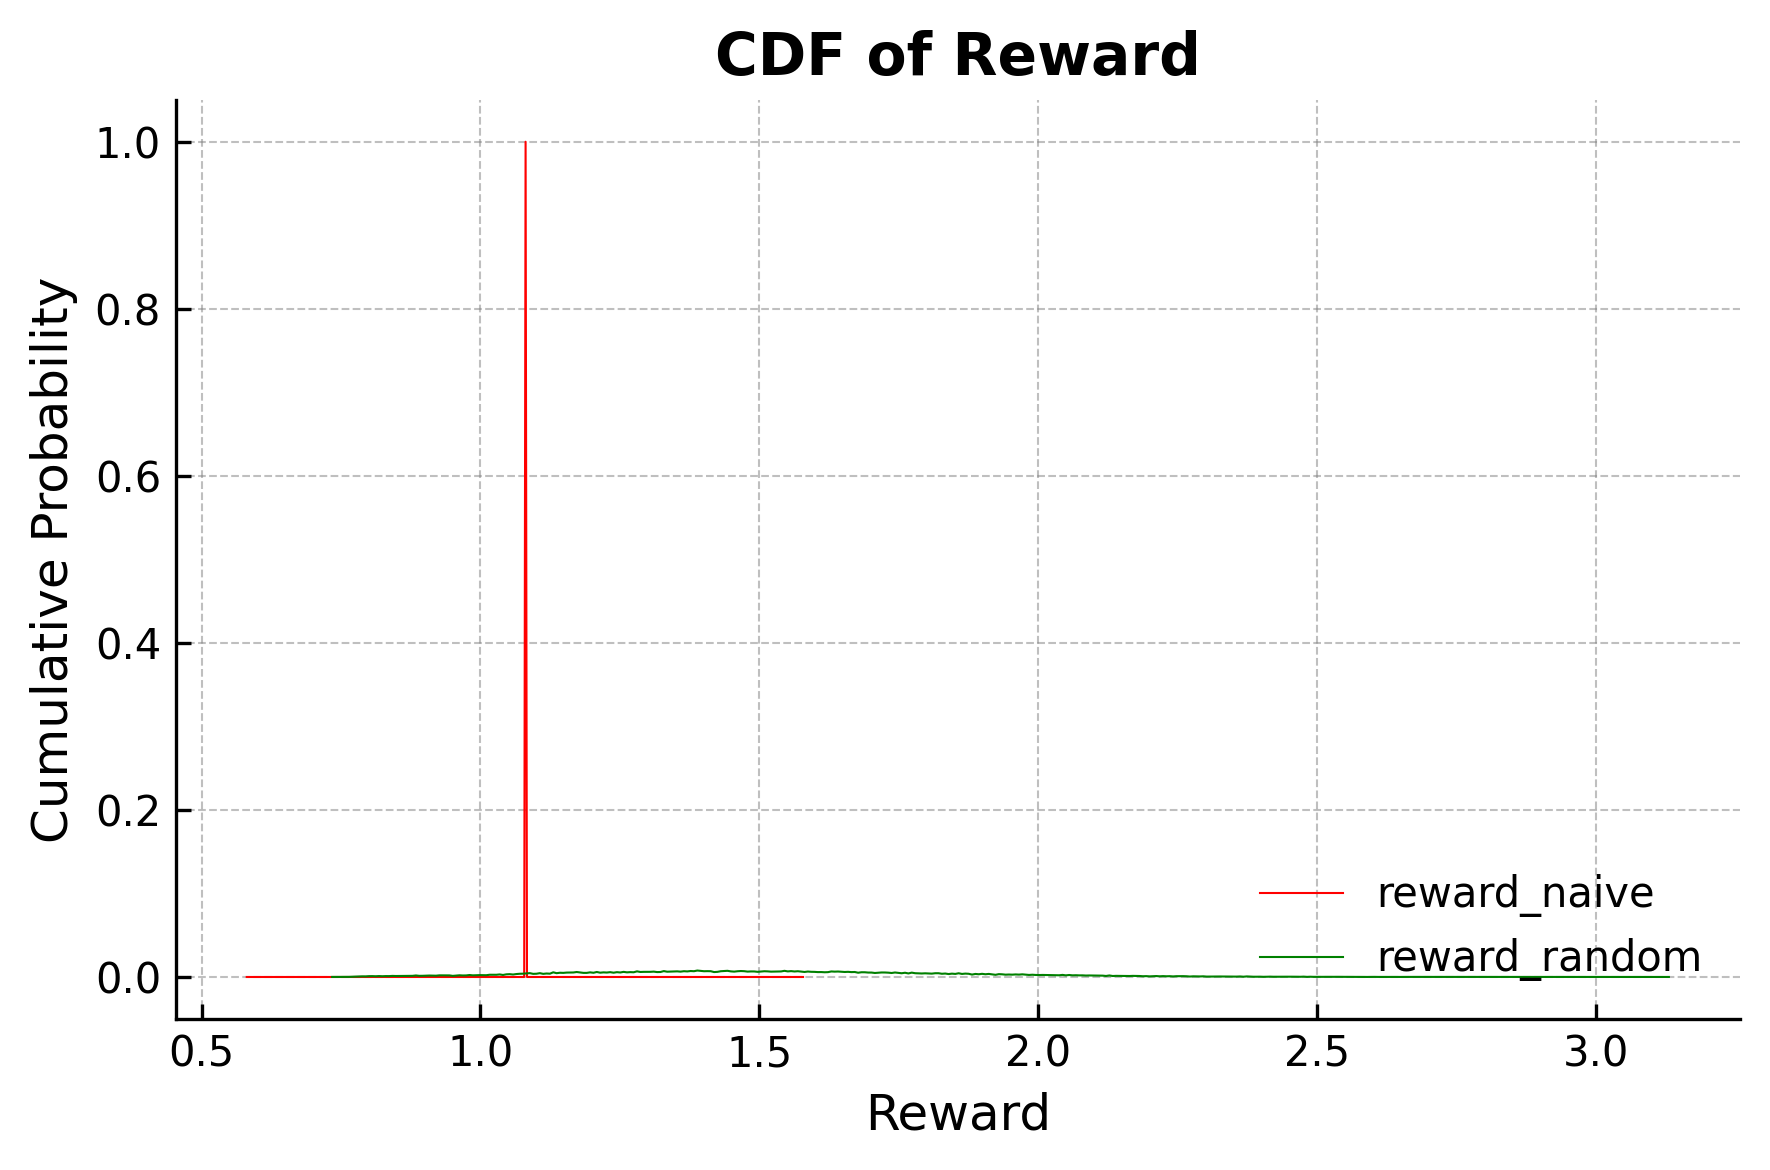

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
x = np.linspace(0, 40000, 40000)
y1 = np.array(reward_naive) 
y2= np.array(reward_rand) 


# cal cdf
def cal_cdf(y_in):
    hist, bin_edges = np.histogram(y_in,bins=400)
    y_cdf = np.cumsum(hist/np.sum(hist))
    # return bin_edges[1:],y_cdf
    return bin_edges[1:],hist/np.sum(hist)

bin1,y1_cdf = cal_cdf(y1)
bin2,y2_cdf = cal_cdf(y2)
# Create figure
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
ax.plot(bin1,y1_cdf,label='reward_naive',color='r', linewidth=0.5)
ax.plot(bin2,y2_cdf,label='reward_random',color='g', linewidth=0.5)

# Set axis labels
ax.set_xlabel('Reward', fontsize=12)
ax.set_ylabel('Cumulative Probability', fontsize=12)

# Set title
ax.set_title('CDF of Reward', fontsize=14, fontweight='bold')

# Set legend
ax.legend(loc='lower right', fontsize=10, frameon=False)

# Set tick parameters
ax.tick_params(axis='both', which='both', direction='in', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set grid
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# Set figure layout
fig.tight_layout()

# Show figure
plt.show()


In [13]:
env = ISAC_BS(N=8,N_c=8,N_r=2)
env._get_state().shape

(144,)

In [ ]:
a = np.eye([8])
b = np.array([1,2,3,1,2,3,1,2,3])